# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1VERPjEZcC1XSs4-02aM-DbkNr_yaJVbFjLJxaYQswqA/edit#)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add prose and code as you wish._

_Anything in italics (prose) or comments (in code) is meant to provide you with guidance. **Remove the italic lines and provided comments** before submitting the project, if you choose to use this scaffolding. We don't need the guidance when grading._

_**All code below should be consider "pseudo-code" - not functional by itself, and only a suggestion at the approach.**_

## Requirements

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project._

* Code clarity: make sure the code conforms to:
    * [ ] [PEP 8](https://peps.python.org/pep-0008/) - You might find [this resource](https://realpython.com/python-pep8/) helpful as well as [this](https://github.com/dnanhkhoa/nb_black) or [this](https://jupyterlab-code-formatter.readthedocs.io/en/latest/) tool
    * [ ] [PEP 257](https://peps.python.org/pep-0257/)
    * [ ] Break each task down into logical functions
* The following files are submitted for the project (see the project's GDoc for more details):
    * [ ] `README.md`
    * [ ] `requirements.txt`
    * [ ] `.gitignore`
    * [ ] `schema.sql`
    * [ ] 6 query files (using the `.sql` extension), appropriately named for the purpose of the query
    * [x] Jupyter Notebook containing the project (this file!)
* [x] You can edit this cell and add a `x` inside the `[ ]` like this task to denote a completed task

## Project Setup

In [ ]:
# all import statements needed for the project, for example:


import os
import re
import bs4
import math
import requests
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sqlalchemy as db
import geopandas as gpd
import keplergl

In [2]:
# any general notebook setup, like log formatting

In [277]:
#any constants you might need, for example:

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
# add other constants to refer to any local data, e.g. uber & weather
UBER_CSV = "uber_rides_sample.csv"
TAXI_ZONES = "taxi_zones.shp"
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

## Part 1: Data Preprocessing

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Define a function that calculates the distance between two coordinates in kilometers that **only uses the `math` module** from the standard library.
* [ ] Taxi data:
    * [ ] Use the `re` module, and the packages `requests`, BeautifulSoup (`bs4`), and (optionally) `pandas` to programmatically download the required CSV files & load into memory.
    * You may need to do this one file at a time - download, clean, sample. You can cache the sampling by saving it as a CSV file (and thereby freeing up memory on your computer) before moving onto the next file. 
* [ ] Weather & Uber data:
    * [ ] Download the data manually in the link provided in the project doc.
* [ ] All data:
    * [ ] Load the data using `pandas`
    * [ ] Clean the data, including:
        * Remove unnecessary columns
        * Remove invalid data points (take a moment to consider what's invalid)
        * Normalize column names
        * (Taxi & Uber data) Remove trips that start and/or end outside the designated [coordinate box](http://bboxfinder.com/#40.560445,-74.242330,40.908524,-73.717047)
    * [ ] (Taxi data) Sample the data so that you have roughly the same amount of data points over the given date range for both Taxi data and Uber data.
* [ ] Weather data:
    * [ ] Split into two `pandas` DataFrames: one for required hourly data, and one for the required daily daya.
    * [ ] You may find that the weather data you need later on does not exist at the frequency needed (daily vs hourly). You may calculate/generate samples from one to populate the other. Just document what you’re doing so we can follow along. 

### Calculating distance
From latitude and longitude to caluclate the distance. We refer to the formular from: https://en.wikipedia.org/wiki/Geographical_distance 

In [278]:
def calculate_distance(from_coord: pd.core.frame.DataFrame, to_coord: pd.core.frame.DataFrame) -> pd.core.series.Series:
    """Caluclate the distance from latitude and longitude.

    Keyword arguments:
    from_coord -- A dataframe including 'pickup_latitude' and 'pickup_longitude'
    to_coord -- A dataframe including 'dropoff_latitude' and 'dropoff_longitude'

    Output:
    A series of the distances (km).
    """

    # convert different degrees into radians
    pickup_larad = from_coord['pickup_latitude'].apply(math.radians)
    pickup_lorad = from_coord['pickup_longitude'].apply(math.radians)
    dropoff_larad = to_coord['dropoff_latitude'].apply(math.radians)
    dropoff_lorad = to_coord['dropoff_longitude'].apply(math.radians)

    # calculate the distance
    R = 6371 
    la_dif = pickup_larad - dropoff_larad
    lo_dif = pickup_lorad - dropoff_lorad
    a = ((la_dif / 2).apply(math.sin)) ** 2 + pickup_larad.apply(math.cos) * dropoff_larad.apply(math.cos) * ((lo_dif / 2).apply(math.sin) ** 2)
    distance = 2 * R * a.apply(math.sqrt).apply(math.asin)
    
    return distance

Add the distance information to the original dataframe.

In [279]:
def add_distance_column(dataframe: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    '''Add the distance information to the original dataframe.
    
    Keyword arguments:
    df -- A dataframe with columns "pickup_latitude" , "pickup_longitude",  "dropoff_latitude" and "dropoff_longitude".

    Output:
    A dataframe with a new column "distance"
    '''

    from_pos = dataframe[['pickup_latitude', 'pickup_longitude']]
    to_pos = dataframe[['dropoff_latitude', 'dropoff_longitude']]
    dataframe['distance'] = calculate_distance(from_pos, to_pos)
    
    return dataframe

### Processing Taxi Data

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [280]:
def find_taxi_parquet_urls(taxi_url = TAXI_URL) -> list:
    '''
    Go get the URLs of parquet file for taxi data.
    Returns A list of urls that point to the parquet files.
    '''
    response = requests.get(taxi_url)
    html = response.content
    taxisoup = bs4.BeautifulSoup(html, 'html.parser')
    links = taxisoup.find_all("a", href=True)

    urllist = []
    for link in links:
        if re.search(r"yellow_tripdata_2009|yellow_tripdata_201[01234]|yellow_tripdata_2015-0[1-6]", link.get("href")):
            urllist.append(link.get("href"))
        # Regular expression to find the links that match the pattern 2009-01~2015-06
    return urllist
# myurl = find_taxi_parquet_urls()
# print(myurl)


In [282]:
def Download_data(localurl: str)-> pd.core.frame.DataFrame:    
    '''
    Download the data to local file path if there is non exist.
    url -- a string which is the url of the parquet file.
    return a dataframe that can we can further work on. 
    '''
    # Get the file name with given url
    filename = localurl.split('/')[-1]
    # download the file if it doesn't exist
    file = requests.get(localurl)
    with open(filename , "wb") as f:
        f.write(file.content)
    # load the data with read_parquet
    df = pd.read_parquet(filename)
    #df.to_csv(filename+".csv")
    return df
# Download_data('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-01.parquet')

def get_taxi_zone_df() -> gpd.geodataframe.GeoDataFrame:
    """
    Get a GeoDataFrame
    """
    taxi_zone_df = gpd.read_file(filename='taxi_zones.zip', engine='fiona')
    # taxi_zone_df = gpd.read_file(TAXI_ZONES)
    taxi_zone_df = taxi_zone_df.to_crs(4326)
    taxi_zone_df['longitude'] = taxi_zone_df.centroid.x
    taxi_zone_df['latitude'] = taxi_zone_df.centroid.y
    taxi_zone_df.drop_duplicates('LocationID', inplace = True)
    taxi_zone_df.set_index('LocationID', inplace = True)
    return taxi_zone_df
# mypandas = get_taxi_zone_df()
# print(type((mypandas)))


def Clean_month_taxi_data(url: str, GEOmetry: gpd.geodataframe.GeoDataFrame) -> pd.core.frame.DataFrame:
    '''
    Download the data to local and Clean the taxi data for a given month.
    url -- a string which is the url of the parquet file.
    Returns A pandas dataframe
    '''
    # Call download_data fucntion to download data from url and return csv
    df = Download_data(localurl = url)
    print("cleaning data from", url)
    # looking up the latitude and longitude for some months where only location IDs are given for pickups and dropoffs
    if 'PULocationID' in df.columns:
        df['pickup_latitude'] = df['PULocationID'].map(GEOmetry['latitude'])
        df['pickup_longitude'] = df['PULocationID'].map(GEOmetry['longitude'])
        df['dropoff_latitude'] = df['DOLocationID'].map(GEOmetry['latitude'])
        df['dropoff_longitude'] = df['DOLocationID'].map(GEOmetry['longitude'])
    # Get rid of the NA's, which indicate a poor quality of the data.
    df.dropna()
    # normalizing column names
    df.rename(columns={'tpep_pickup_datetime':'pickup_datetime','\
        Trip_Pickup_DateTime':'pickup_datetime',\
        'Trip_Dropoff_DateTime':'dropoff_datetime',\
        'tpep_dropoff_datetime':'dropoff_datetime',\
        'Start_Lon':'pickup_longitude', \
        'Start_Lat':'pickup_latitude', \
        'End_Lon':'dropoff_longitude', \
        'End_Lat':'dropoff_latitude',
        'Tip_Amt':'tip_amount'}, inplace=True)
    # normalizing and using appropriate column types for the respective data
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

    # removing trips that start and/or end outside of the NEW_YORK_BOX_COORDS
    df = df[(df['pickup_latitude'] >= NEW_YORK_BOX_COORDS[0][0]) & (df['pickup_latitude'] <= NEW_YORK_BOX_COORDS[1][0])]
    df = df[(df['pickup_longitude'] >= NEW_YORK_BOX_COORDS[0][1]) & (df['pickup_longitude'] <= NEW_YORK_BOX_COORDS[1][1])]
    df = df[(df['dropoff_latitude'] >= NEW_YORK_BOX_COORDS[0][0]) & (df['dropoff_latitude'] <= NEW_YORK_BOX_COORDS[1][0])]
    df = df[(df['dropoff_longitude'] >= NEW_YORK_BOX_COORDS[0][1]) & (df['dropoff_longitude'] <= NEW_YORK_BOX_COORDS[1][1])]


    # leaving only needed data columns, by selecting what's needed
    df = df[['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_datetime','dropoff_longitude','dropoff_latitude','tip_amount']]

    # sample the data to make it roughly equal to the size of the Uber dataset
    # ~200000 is the number of rows in the Uber dataset
    # so every month we sample 200000 / 78 ~ 2500 rows
    df = df.sample(n=2500)
    return df


In [311]:
def get_and_clean_taxi_data():
    all_taxi_dataframes = []
    all_urls = find_taxi_parquet_urls(TAXI_URL)
    print(all_urls[0])
    GEOmetry = get_taxi_zone_df()
    # for one_url in all_urls:
    count = 1
    for one_url in [all_urls[0], all_urls[1]]:
        print(one_url)
        print("processing dataset" + str(count))
        dataframe = Clean_month_taxi_data(one_url, GEOmetry)
        add_distance_column(dataframe)
        all_taxi_dataframes.append(dataframe)
    taxi_data = pd.concat(all_taxi_dataframes)
    return taxi_data




### Processing Uber Data

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [284]:
def clean_uber_data(csv_file):
    df = pd.read_csv(csv_file)
    df = df.drop(columns=["Unnamed: 0","key"])
    df = df.dropna()
    
    #pick up in bounding box 
    df = df[(df['pickup_longitude']> NEW_YORK_BOX_COORDS[0][1]) &  (df['pickup_longitude']<NEW_YORK_BOX_COORDS[1][1])]
    df = df[(df['pickup_latitude']> NEW_YORK_BOX_COORDS[0][0]) &  (df['pickup_latitude']<NEW_YORK_BOX_COORDS[1][0])]
    #drop off in bounding box  
    df = df[(df['dropoff_longitude']> NEW_YORK_BOX_COORDS[0][1]) &  (df['dropoff_longitude']<NEW_YORK_BOX_COORDS[1][1])]
    df = df[(df['dropoff_latitude']> NEW_YORK_BOX_COORDS[0][0]) &  (df['dropoff_latitude']<NEW_YORK_BOX_COORDS[1][0])]
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df = df[['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']]
    return df

In [285]:
def get_uber_data():
    uber_dataframe = clean_uber_data(UBER_CSV)
    add_distance_column(uber_dataframe)
    return uber_dataframe

### Processing Weather Data

Load and clean the hourly windspeed and precipitation data.

In [286]:
def clean_month_weather_data_hourly(csv_file: str) -> pd.core.frame.DataFrame:
    '''Load the weather data and clean it hourly.
    
    Keyword arguments:
    csv_file -- The name of the raw data csv file.

    Output:
    A dataframe of the cleaned hourly weather data.
    '''

    # we only need hourly windspeed and precipitation
    df = pd.read_csv(csv_file, usecols=['DATE','HourlyWindSpeed','HourlyPrecipitation'])
    
    # process date type
    df['DATE'] = pd.to_datetime(df['DATE'])

    # deal with missing values
    df.dropna(subset=['HourlyWindSpeed'], inplace=True)
    df['HourlyPrecipitation'] = pd.to_numeric(df['HourlyPrecipitation'], errors='coerce')
    df['HourlyPrecipitation'].fillna(0, inplace=True)

    return df

Load and clean the daily windspeed and precipitation data.

In [370]:
def clean_month_weather_data_daily(csv_file: str) -> pd.core.frame.DataFrame:
    '''Load the weather data and clean it daily.
    
    Keyword arguments:
    csv_file -- The name of the raw data csv file.

    Output:
    A dataframe with the cleaned daily weather data.
    '''

    # we only need daily windspeed and precipitation
    df = pd.read_csv(csv_file, usecols=['DATE','HourlyWindSpeed','HourlyPrecipitation'])

    # deal with missing values
    df.dropna(subset=['HourlyWindSpeed'], inplace=True)
    df['HourlyPrecipitation'] = pd.to_numeric(df['HourlyPrecipitation'], errors='coerce')
    df['HourlyPrecipitation'].fillna(0, inplace=True)

    # group by day and calculate mean(HourlyWindSpeed) and sum(HourlyPrecipitation)
    df['DATE'] = pd.to_datetime(df['DATE'])
    df['DATE'] = df['DATE'].dt.date
    daily_wind_speed = df[['DATE', 'HourlyWindSpeed']].groupby('DATE').mean()
    daily_precipitation = df[['DATE', 'HourlyPrecipitation']].groupby('DATE').sum()
    daily_wind_speed.rename(columns = {'HourlyWindSpeed':'DailyWindSpeed'}, inplace = True)
    daily_precipitation.rename(columns= {'HourlyPrecipitation':'DailyWindSpeed'}, inplace = True)
    df2 = pd.concat([daily_wind_speed, daily_precipitation], axis=1)
    df2=df2.set_axis(['DailyWindSpeed', 'DailyPrecipitation'], axis=1, inplace=False)
    return df2

Load the sunrise and sunset time of each day.

In [288]:
def clean_month_sun_data_daily(csv_file: str) -> pd.core.frame.DataFrame:
    '''Load the sunrise and sunset time of each day.
    
    Keyword arguments:
    csv_file -- The name of the raw data csv file.

    Output:
    A dataframe with the sunrise and sunset time of each day.
    '''

    # load data
    df = pd.read_csv(csv_file, usecols=['DATE','Sunrise','Sunset'])
    
    # process date type
    df['DATE'] = pd.to_datetime(df['DATE'])
    df['DATE'] = df['DATE'].dt.date
    df.drop('DATE', axis=1, inplace=True)

    # deal with redundant data
    df.dropna(subset=['Sunrise'], inplace=True)
    
    return df

Load and clean all weather and sun data from 2009 to 2015.

In [289]:
def load_and_clean_weather_data():
    hourly_dataframes = []
    daily_dataframes = []
    sun_dataframes = []
    
    # add the name/paths manually
    weather_csv_files = ["2009_weather.csv", "2010_weather.csv", "2011_weather.csv", "2012_weather.csv",
                         "2013_weather.csv", "2014_weather.csv", "2015_weather.csv"]
    
    for csv_file in weather_csv_files:
        csv_path = 'weather/'
        hourly_dataframe = clean_month_weather_data_hourly(csv_path + csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_path + csv_file)
        sun_dataframe = clean_month_sun_data_daily(csv_path + csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        sun_dataframes.append(sun_dataframe)
        
    # create three dataframes with hourly, daily data and sun from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    sun_data = pd.concat(sun_dataframes)
    
    return hourly_data, daily_data, sun_data

### Process All Data

_This is where you can actually execute all the required functions._

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [373]:
hourly_data

,DATE,HourlyPrecipitation,HourlyWindSpeed
0,2009-01-01 00:51:00,0.0,18.0
1,2009-01-01 01:51:00,0.0,18.0
2,2009-01-01 02:51:00,0.0,18.0
3,2009-01-01 03:51:00,0.0,8.0
4,2009-01-01 04:51:00,0.0,11.0
...,...,...,...
11379,2015-12-31 18:51:00,0.0,3.0
11380,2015-12-31 19:51:00,0.0,6.0
11381,2015-12-31 20:51:00,0.0,10.0
11383,2015-12-31 22:51:00,0.0,7.0


In [374]:
print(daily_data)

            DailyWindSpeed  DailyPrecipitation
DATE                                          
2009-01-01       11.041667                0.00
2009-01-02        6.806452                0.00
2009-01-03        9.875000                0.00
2009-01-04        7.370370                0.00
2009-01-05        6.925926                0.00
...                    ...                 ...
2015-12-27        4.911111                0.17
2015-12-28        8.208333                0.03
2015-12-29        7.787234                0.93
2015-12-30        4.184211                0.29
2015-12-31        4.741935                0.08

[2541 rows x 2 columns]


In [371]:
hourly_data, daily_data, sun_data = load_and_clean_weather_data()

In [312]:
taxi_data = get_and_clean_taxi_data()
uber_data = get_uber_data()
hourly_data, daily_data, sun_data = load_and_clean_weather_data()


https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-01.parquet


<ipython-input-282-104f6b2806cd>:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  taxi_zone_df['longitude'] = taxi_zone_df.centroid.x
<ipython-input-282-104f6b2806cd>:27: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  taxi_zone_df['latitude'] = taxi_zone_df.centroid.y


https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-01.parquet
processing dataset1
cleaning data from https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-01.parquet
https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-02.parquet
processing dataset1
cleaning data from https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-02.parquet


## Part 2: Storing Cleaned Data

_Write some prose that tells the reader what you're about to do here._

In [337]:
engine = db.create_engine(DATABASE_URL)

In [339]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = \
"""
CREATE TABLE IF NOT EXISTS hourly_weather (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    DATE DATE,
    HourlyWindSpeed FLOAT,
    HourlyPrecipitation FLOAT
);
"""

DAILY_WEATHER_SCHEMA =\
"""
CREATE TABLE IF NOT EXISTS daily_weather (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    DATE DATE,
    DailyWindSpeed FLOAT,
    DailyPrecipitation FLOAT
);
"""

TAXI_TRIPS_SCHEMA = \
"""
CREATE TABLE IF NOT EXISTS taxi_trips (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    pickup_datetime DATE,
    dropoff_datetime DATE,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    tip_amount FLOAT,
    distance FLOAT
);
"""

UBER_TRIPS_SCHEMA =\
"""
CREATE TABLE IF NOT EXISTS uber_trips (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    pickup_datetime DATE,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    distance FLOAT
);
"""

SUN_SCHEMA = \
"""
CREATE TABLE IF NOT EXISTS sun_data (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    DATE DATE,
    Sunrise INT,
    Sunset INT
);
"""


In [340]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)
    f.write(SUN_SCHEMA)

In [341]:
# create the tables with the schema files
with engine.connect() as connection:
    sql = open(DATABASE_SCHEMA_FILE, "r")
    commands = sql.read().split(";")
    sql.close()
    for command in commands:
        connection.execute(command)


### Add Data to Database

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [342]:
def write_dataframes_to_table(table_to_df_dict: dict):
    """
    high
    """
    for i, j in table_to_df_dict.items():
        j.to_sql(i,engine, if_exists = 'append', index = False)
    return

In [359]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_data,
    "daily_weather": daily_data,
    "sun_data": sun_data
}

In [360]:
write_dataframes_to_table(map_table_name_to_dataframe)

## Part 3: Understanding the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins.
* [ ] For the same time frame, what day of the week was the most popular to take an uber? The result should have 7 bins.
* [ ] What is the 95% percentile of distance traveled for all hired trips during July 2013?
* [ ] What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?
* [ ] Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?
* [ ] During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

In [18]:
def write_query_to_file(query, outfile):
    raise NotImplemented()

### Query N

_**TODO:** Write some prose that tells the reader what you're about to do here._

_Repeat for each query_

In [ ]:
QUERY_N = """
TODO
"""

In [ ]:
engine.execute(QUERY_N).fetchall()

In [ ]:
write_query_to_file(QUERY_N, "some_descriptive_name.sql")

## Part 4: Visualizing the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Create an appropriate visualization for the first query/question in part 3
* [ ] Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization
* [ ] Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.
* [ ] Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.
* [ ] Create a scatter plot that compares tip amount versus distance.
* [ ] Create another scatter plot that compares tip amount versus precipitation amount.

_Be sure these cells are executed so that the visualizations are rendered when the notebook is submitted._

### Visualization 4


In [ ]:

w1 = keplergl.KeplerGl(height=600, data={'data_1': df})
w1

<ipython-input-282-104f6b2806cd>:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  taxi_zone_df['longitude'] = taxi_zone_df.centroid.x
<ipython-input-282-104f6b2806cd>:27: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  taxi_zone_df['latitude'] = taxi_zone_df.centroid.y


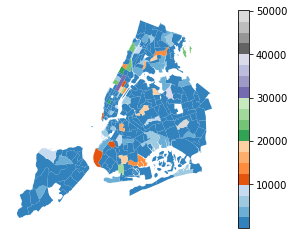

In [376]:
def heatmap_for_trips():
    """Make a heatmap of all hired trips over a map of the area."""
    
    query = '''WITH hired_trips AS (SELECT pickup_latitude AS latitude, pickup_longitude AS longitude
            FROM taxi_trips UNION ALL
            SELECT pickup_latitude AS latitude, pickup_longitude AS longitude FROM uber_trips)
            SELECT latitude, longitude
            FROM hired_trips
            '''
    df = pd.read_sql_query(query, engine)
    
    # reindex the GEO
    geoloc = get_taxi_zone_df()
    geo_loc = geoloc.reset_index()

    # make a key from the latitude and longitude
    geoloc['key'] = geo_loc['latitude'] ** 2 +  geo_loc['longitude'] ** 2
    df['key'] = df['latitude'] ** 2 +  df['longitude'] ** 2

    # sort the key
    geo_loc.sort_values(by='key', inplace=True)
    df.sort_values(by='key', inplace=True)

    # join the two dataframes
    df = pd.merge_asof(df, geo_loc, left_on=["key"], right_on=["key"])
    df.dropna(subset=["LocationID"], inplace=True)

    geo_loc['num'] = df.groupby("LocationID").count()['key']
    geo_loc.plot(column='num', cmap='tab20c', legend=True, markersize = 10)
    plt.axis('off')
    plt.show()
    
heatmap_for_trips()

### Visualization 5

_**TODO:** Write some prose that tells the reader what you're about to do here._

_Repeat for each visualization._

_The example below makes use of the `matplotlib` library. There are other libraries, including `pandas` built-in plotting library, kepler for geospatial data representation, `seaborn`, and others._

In [321]:

def tip_amount_vs_distance_scatter_plot(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))

    axes.scatter("distance","tip_amount", data = dataframe)
    axes.set_title("Tip Amount & Travel Distance")
    axes.set_xlabel("Distance")
    axes.set_ylabel("Tip Amount")
    
    plt.show()

In [322]:
def get_data_for_visual_5():
    """
    return a dataframe that can be further used for p
    """
    myquery = \
    '''SELECT tip_amount, distance
    FROM taxi_trips
    '''
    df = pd.read_sql_query(myquery, engine)
    return df

      tip_amount  distance
0           0.00       NaN
1           0.00       NaN
2           2.70       NaN
3           2.45       NaN
4           1.00       NaN
...          ...       ...
9995        2.00  3.750545
9996        2.70  2.324131
9997        0.00  1.225479
9998        0.00  1.174113
9999        0.00  1.670501

[10000 rows x 2 columns]


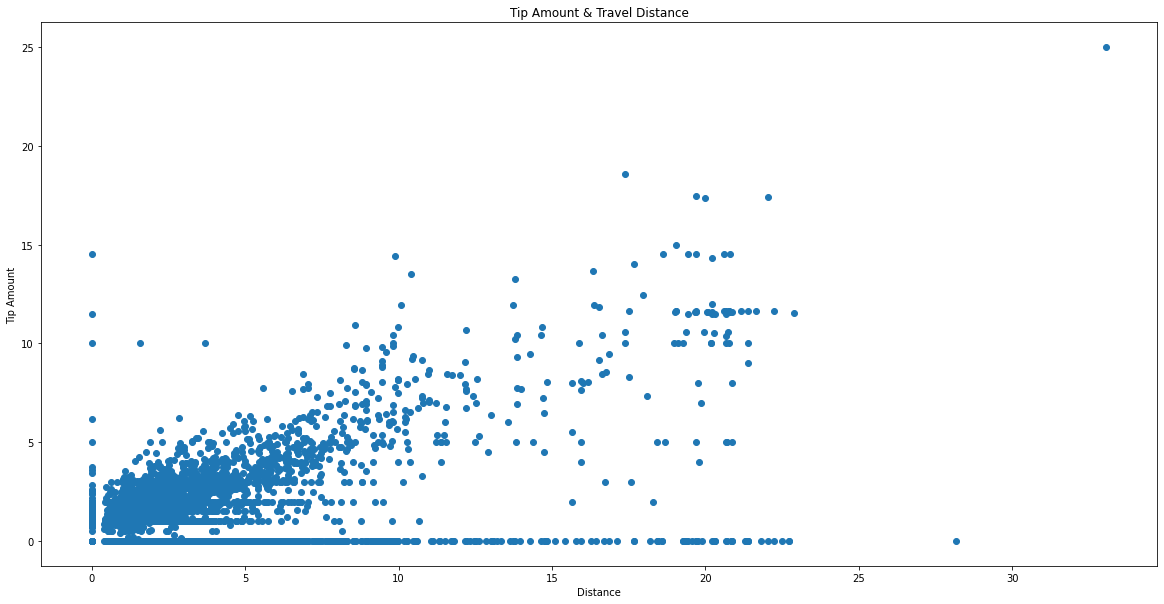

In [323]:
some_dataframe = get_data_for_visual_5()
print(some_dataframe)
tip_amount_vs_distance_scatter_plot(some_dataframe)

### Visualization 1

_**TODO:** Write some prose that tells the reader what you're about to do here._

_Repeat for each visualization._

_The example below makes use of the `matplotlib` library. There are other libraries, including `pandas` built-in plotting library, kepler for geospatial data representation, `seaborn`, and others._

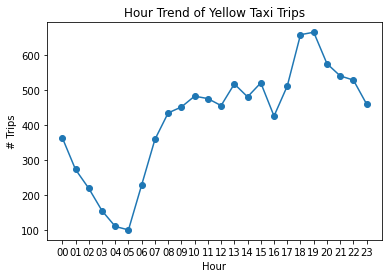

In [331]:
def time_trend_taxi(dataframe: pd.core.frame.DataFrame):
    '''Plot a line chart for the time trend of yellow taxi trips.
    
    Keyword arguments:
    dataframe -- the dataframe for time trend of yellow taxi trips
    '''
    
    data = dataframe.sort_values(by="hour", ascending=True)
    plt.plot(data["hour"],data["trip_count"],"o-")
    plt.xlabel('Hour')
    plt.ylabel('# Trips')
    plt.title('Hour Trend of Yellow Taxi Trips')
    plt.show()
def get_time_trend_taxi_data():
    '''Return time trend data for yellow taxi trips.'''
    
    query = """
    SELECT strftime('%H', pickup_datetime) AS hour, 
           COUNT(*) AS trip_count
    FROM taxi_trips
    GROUP BY hour
    ORDER BY trip_count DESC;
    """
    
    df = pd.read_sql_query(query, engine)
    
    return df

time_trend_taxi_dataframe = get_time_trend_taxi_data()
time_trend_taxi(time_trend_taxi_dataframe)

### Visualization 6

_**TODO:** Write some prose that tells the reader what you're about to do here._

_Repeat for each visualization._

_The example below makes use of the `matplotlib` library. There are other libraries, including `pandas` built-in plotting library, kepler for geospatial data representation, `seaborn`, and others._aa


            id                        DATE  HourlyWindSpeed  \
0            1  2009-01-01 00:51:00.000000             18.0   
1            2  2009-01-01 01:51:00.000000             18.0   
2            3  2009-01-01 02:51:00.000000             18.0   
3            4  2009-01-01 03:51:00.000000              8.0   
4            5  2009-01-01 04:51:00.000000             11.0   
...        ...                         ...              ...   
294847  294848  2015-12-31 18:51:00.000000              3.0   
294848  294849  2015-12-31 19:51:00.000000              6.0   
294849  294850  2015-12-31 20:51:00.000000             10.0   
294850  294851  2015-12-31 22:51:00.000000              7.0   
294851  294852  2015-12-31 23:51:00.000000              5.0   

        HourlyPrecipitation  
0                       0.0  
1                       0.0  
2                       0.0  
3                       0.0  
4                       0.0  
...                     ...  
294847                  0.0  
294

ValueError: x and y must be the same size

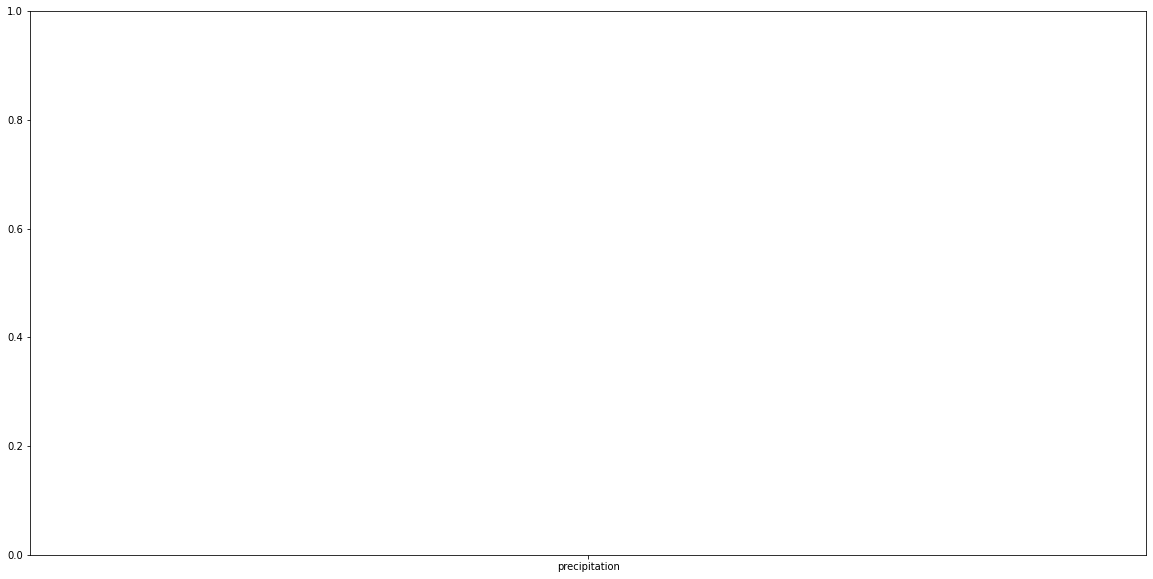

In [364]:
def tip_amount_vs_precipitation_scatter_plot(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))

    axes.scatter("precipitation","tip_amount", data = dataframe)
    axes.set_title("Tip Amount & Precipitation")
    axes.set_xlabel("Precipitation")
    axes.set_ylabel("Tip Amount")
    
    plt.show()

def get_data_for_visual_6():
    """
    return a dataframe that can be further used for plotting
    """
    myquery = \
    '''
    SELECT tip_amount, HourlyPrecipitation
    FROM taxi_trips left join hourly_weather on taxi_trips.pickup_datetime = hourly_weather.DATE;
    '''
    df = pd.read_sql_query(myquery, engine)
    return df

def get_data_for_visual_7():
    """
    return a dataframe that can be further used for plotting
    """
    myquery = \
    '''
    SELECT *
    FROM hourly_weather;
    '''
    df = pd.read_sql_query(myquery, engine)
    return df
data1 = get_data_for_visual_7()
print(data1)
some_dataframe = get_data_for_visual_6()
print(some_dataframe)
tip_amount_vs_precipitation_scatter_plot(some_dataframe)


